<a href="https://colab.research.google.com/github/ferozferoz/DeepLearn/blob/master/timeseries_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
f = open('/content/gdrive/My Drive/ColabNotebooks/jena_climate_2009_2016/jena_climate_2009_2016.csv','r',encoding='UTF-8')
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
body = lines[1:]
"""the data in list will be moved to the numpy array  """

data_list = np.zeros((len(body),len(header)-1))
for i,body_data in enumerate(body):
  values = [float(x) for x in body_data.split(',')[1:]]
  data_list[i,:] = values

print(data_list[:4])
print(data_list.shape[-1])


[[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
   3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
   1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
 [ 9.96570e+02 -8.41000e+00  2.65010e+02 -9.28000e+00  9.34000e+01
   3.23000e+00  3.02000e+00  2.10000e-01  1.89000e+00  3.03000e+00
   1.30980e+03  7.20000e-01  1.50000e+00  1.36100e+02]
 [ 9.96530e+02 -8.51000e+00  2.64910e+02 -9.31000e+00  9.39000e+01
   3.21000e+00  3.01000e+00  2.00000e-01  1.88000e+00  3.02000e+00
   1.31024e+03  1.90000e-01  6.30000e-01  1.71600e+02]
 [ 9.96510e+02 -8.31000e+00  2.65120e+02 -9.07000e+00  9.42000e+01
   3.26000e+00  3.07000e+00  1.90000e-01  1.92000e+00  3.08000e+00
   1.30919e+03  3.40000e-01  5.00000e-01  1.98000e+02]]
14


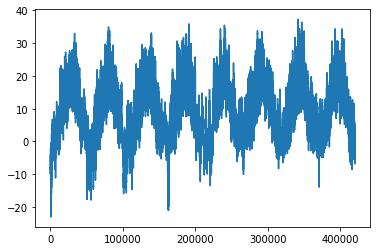

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(len(data_list)),data_list[:,1]) ## clearly there is periodicity in data on long term basis


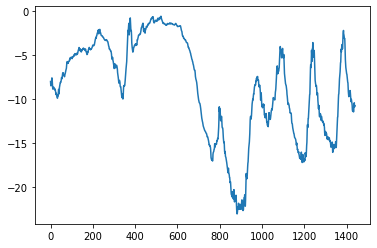

In [6]:
plt.plot(data_list[:1440,1]) # in 10 days worth of data periodicity is not observed

In [8]:
mean = data_list[:200000].mean(axis=0)
data_list -= mean
std = data_list[:200000].std(axis=0)
data_list /= std

data_list[:1,]

array([[ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
        -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
         2.12375056, -0.72950452, -0.78067973, -0.27613603]])

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [27]:
train_gen = generator(data_list,lookback=lookback,delay=delay,min_index=0,max_index=20000,shuffle=True,step=step,batch_size=batch_size)
validation_gen = generator(data_list,lookback=lookback,delay=delay,min_index=20001,max_index=30000,shuffle=True,step=step,batch_size=batch_size)
test_gen = generator(data_list,lookback=lookback,delay=delay,min_index=30001,max_index=None,shuffle=True,step=step,batch_size=batch_size)

val_steps = (30000 - 20001 - lookback)
test_steps = (len(data_list) - 30001 - lookback)
print(data_list.shape)
x = next(train_gen)
print(x[0].shape)


(420551, 14)
(128, 240, 14)


In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, data_list.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=5,
                              epochs=5,
                              validation_data=validation_gen,validation_steps=val_steps
                              )

Epoch 1/5
5/5 [==============================] - 75s 15s/step - loss: 1.9150 - val_loss: 1.4950
Epoch 2/5
5/5 [==============================] - 75s 15s/step - loss: 0.8059 - val_loss: 2.1063
Epoch 3/5
5/5 [==============================] - 75s 15s/step - loss: 0.6859 - val_loss: 1.5918
Epoch 4/5
5/5 [==============================] - 76s 15s/step - loss: 0.4886 - val_loss: 4.3332
Epoch 5/5
5/5 [==============================] - 76s 15s/step - loss: 0.4285 - val_loss: 1.8982


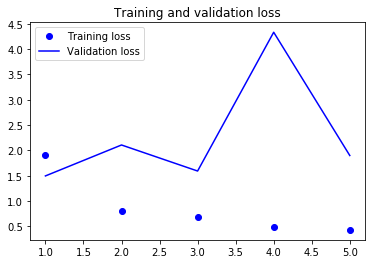

In [23]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
model1 = Sequential()
model1.add(layers.GRU(32,input_shape=(240,14)))
model1.add(layers.Dense(1))
model1.summary()
model1.compile(optimizer=RMSprop(),loss='mae')
history1 = model.fit_generator(train_gen,
steps_per_epoch=5,
epochs=20,
validation_data=validation_gen,
validation_steps=val_steps)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5/5 [==============================] - 77s 15s/step - loss: 0.4245 - val_loss: 4.1025
Epoch 2/20
5/5 [==============================] - 78s 16s/step - loss: 0.4738 - val_loss: 2.1840
Epoch 3/20
5/5 [==============================] - 76s 15s/step - loss: 0.3638 - val_loss: 3.2875
Epoch 4/20
5/5 [==============================] - 75s 15s/step - loss: 0.5139 - val_loss: 4.7503
Epoch 5/20
5/5 [==============================] - 76s 15s/step - loss: 0.3287 - val_loss: 1.2396
Epoch 6/20
5/5 [=============

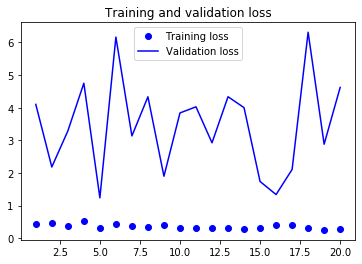

In [33]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [34]:
model2 = Sequential()
model2.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(240,14)))
model2.add(layers.Dense(1))
model2.summary()
model2.compile(optimizer=RMSprop(),loss='mae')
history2 = model.fit_generator(train_gen,
steps_per_epoch=5,
epochs=20,
validation_data=validation_gen,
validation_steps=val_steps)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5/5 [==============================] - 80s 16s/step - loss: 0.2615 - val_loss: 2.8781
Epoch 2/20
5/5 [==============================] - 79s 16s/step - loss: 0.2776 - val_loss: 2.4742
Epoch 3/20
5/5 [==============================] - 79s 16s/step - loss: 0.2477 - val_loss: 1.3846
Epoch 4/20
5/5 [==============================] - 76s 15s/step - loss: 0.3019 - val_loss: 5.6078
Epoch 5/20

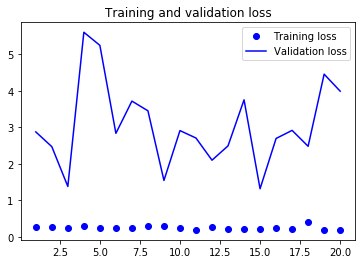

In [35]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()